In [1]:
# Import ML and Preprocessing libraries
import cv2
import numpy as np
import os
import datetime
from skimage import io
import os
import random
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from sklearn import svm
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
# Import Gesture Classes with their respected labeled folders
dataset = glob.glob('data/*')

# Define a list of gesture names
gesture_list = ['blank', 'ok', 'thumbsup', 'thumbsdown', 'fist', 'five']

# Initialize a list to hold loaded images for each class
loaded_images = []

# Initialize the output vectors list
output_vectors = []

# Iterate through each gesture in the gesture list
for gesture_index, gesture in enumerate(gesture_list):
    # Construct the path to the dataset for the current gesture
    gesture_dataset_path = os.path.join("data", gesture)
    # Construct the path to the image files for the current gesture
    gesture_image_path = os.path.join(gesture_dataset_path, '*')
    # Get a list of all image file paths for the current gesture
    gesture_image_file_paths = glob.glob(gesture_image_path)

    # Iterate through each image file path
    for image_file_path in gesture_image_file_paths:
        # Read the image file
        image = cv2.imread(image_file_path)
        # Convert the image to grayscale
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Rotate the image within the range of -45 to 45 degrees
        angle = np.random.randint(-45, 45)      # Randomly select an angle between -45 and 45
        M = cv2.getRotationMatrix2D((grayscale_image.shape[1] // 2, grayscale_image.shape[0] // 2), angle, 1)
        rotated_image = cv2.warpAffine(grayscale_image, M, (grayscale_image.shape[1], grayscale_image.shape[0]))

        # Resize the image
        resized_image = cv2.resize(rotated_image, (120, 120))

        # Append the processed image to the list of loaded images
        loaded_images.append(resized_image)
        # Append the corresponding output vector to the output vectors list
        output_vectors.append(gesture_index)

# Convert the list of loaded images to a numpy array
loaded_images_array = np.array(loaded_images)

# Convert gesture indices to one-hot encoded vectors
output_vectors_array = to_categorical(output_vectors, num_classes=len(gesture_list))

In [4]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(loaded_images_array, output_vectors_array, test_size=0.4, random_state=21)
X_train = X_train.reshape(X_train.shape[0], 120, 120, 1)
X_test = X_test.reshape(X_test.shape[0], 120, 120, 1)


In [5]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Activation, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

# input shape
input_shape = (120, 120, 1)

# number of classes
num_classes = 6

# model
model = Sequential()

# first conv layer
model.add(Conv2D(64, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape)) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# second conv layer
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# third conv layer
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(256, activation='relu')) # fully connected
model.add(Dropout(0.5))

# softmax layer
model.add(Dense(num_classes, activation='softmax'))

# model summary
optimiser = Adam() 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                            verbose=1, 
                                            min_lr=0.001)

# data augmentation
datagen = ImageDataGenerator(
        width_shift_range=0.1,  # shift image left and right
        height_shift_range=0.1,  # shift image up and down
        )


model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 64)      1664      
                                                                 
 batch_normalization (BatchN  (None, 120, 120, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 60, 60, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 60, 60, 128)      5

In [7]:
# Define datagen to modify the learning rate
datagen.fit(X_train)

# Fit the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                              epochs = 12, validation_data = (X_test, y_test),
                              verbose = 1, callbacks=[learning_rate_reduction])

model.save("hand_gesture_recognition_8.h5")

Epoch 1/12
97/97 [==============================] - 324s 3s/step - loss: 0.4679 - categorical_accuracy: 0.8151 - val_loss: 0.1649 - val_categorical_accuracy: 0.9523 - lr: 0.0010
Epoch 2/12
97/97 [==============================] - 342s 4s/step - loss: 0.4036 - categorical_accuracy: 0.8385 - val_loss: 0.0981 - val_categorical_accuracy: 0.9678 - lr: 0.0010
Epoch 3/12
97/97 [==============================] - 346s 4s/step - loss: 0.3722 - categorical_accuracy: 0.8517 - val_loss: 0.0775 - val_categorical_accuracy: 0.9830 - lr: 0.0010
Epoch 4/12
97/97 [==============================] - 334s 3s/step - loss: 0.3573 - categorical_accuracy: 0.8750 - val_loss: 0.0693 - val_categorical_accuracy: 0.9763 - lr: 0.0010
Epoch 5/12
97/97 [==============================] - 355s 4s/step - loss: 0.2930 - categorical_accuracy: 0.8879 - val_loss: 0.0853 - val_categorical_accuracy: 0.9721 - lr: 0.0010
Epoch 6/12
97/97 [==============================] - 385s 4s/step - loss: 0.2349 - categorical_accuracy: 0.9034

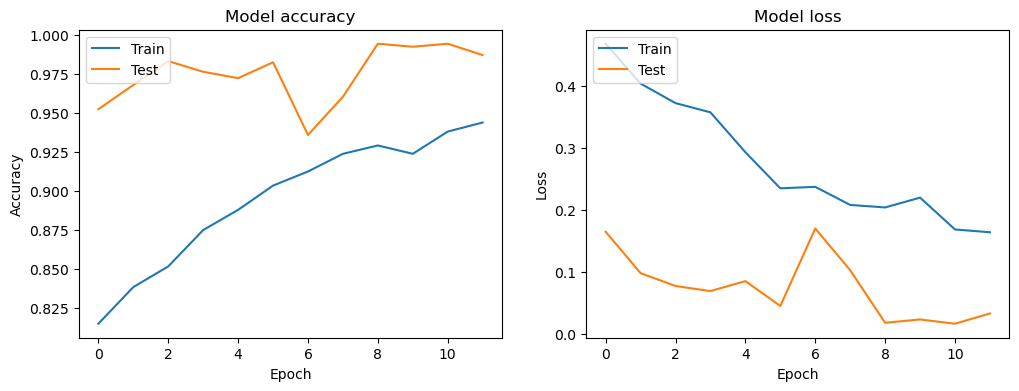

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


In [8]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

print(history.history.keys())


130/130 [==============================] - 43s 329ms/step
Accuracy: 0.9869217728263502


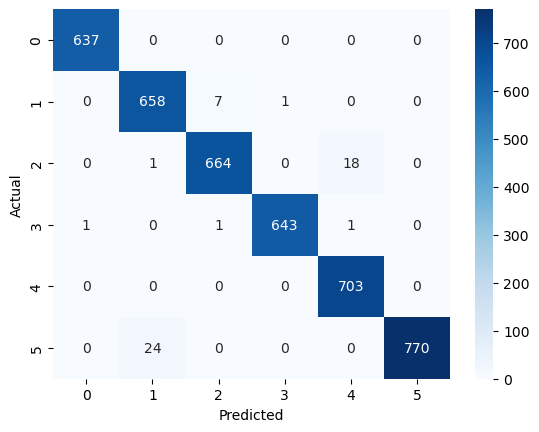

Classification Report:
               precision    recall  f1-score   support

       blank       1.00      1.00      1.00       637
          ok       0.96      0.99      0.98       666
    thumbsup       0.99      0.97      0.98       683
  thumbsdown       1.00      1.00      1.00       646
        fist       0.97      1.00      0.99       703
        five       1.00      0.97      0.98       794

    accuracy                           0.99      4129
   macro avg       0.99      0.99      0.99      4129
weighted avg       0.99      0.99      0.99      4129



In [9]:
# Make predictions on the test set using the saved model
y_pred = model.predict(X_test)

# Convert predicted labels to corresponding class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculate and print accuracy
accuracy = np.mean(y_pred_classes == y_test_classes)
print("Accuracy:", accuracy)

# Calculate and plot confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate and print classification report
report = classification_report(y_test_classes, y_pred_classes, target_names=gesture_list)
print("Classification Report:\n", report)
